In [89]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score


sns.set()

# "What do we have here?"

In [90]:
titanic = pd.read_csv("train.csv")
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [91]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
# Pretend we already know for sure that these are unimportant:
unnecessary = ["PassengerId", "Name","SibSp","Parch","Ticket", "Cabin", "Embarked"]
unnecessary = ["PassengerId", "Name","Ticket", "Embarked"]
unnecessary = ["PassengerId", "Name","Ticket", "Embarked", "Cabin"]

titanic.drop(unnecessary, inplace=True, axis=1)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,NaN,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


In [93]:
titanic.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
dtype: bool

## Quickly figure out how to fill the missing values

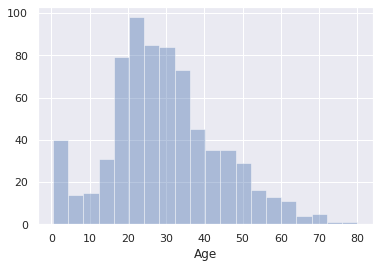

In [94]:
sns.distplot(titanic.Age, norm_hist=False, kde=False)

In [95]:
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

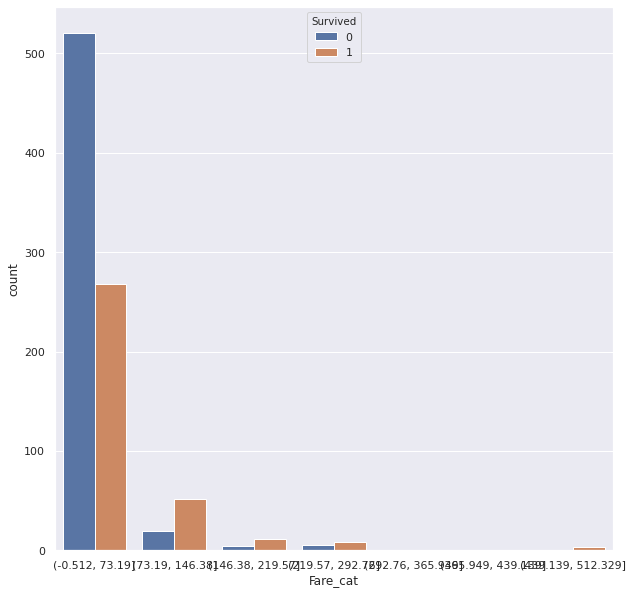

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
titanic["Fare_cat"] = pd.cut(titanic["Fare"], bins = 7)
sns.countplot(data=titanic, x = "Fare_cat", hue = "Survived", ax = ax)

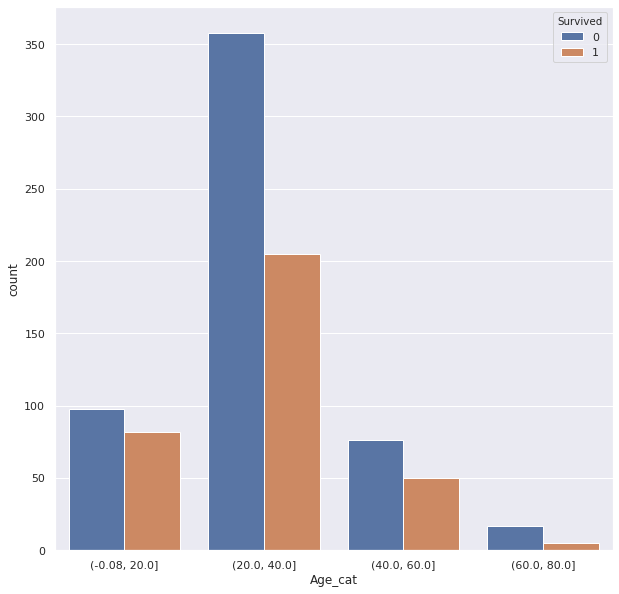

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
titanic["Age_cat"] = pd.cut(titanic["Age"].astype(int), bins = 4)
sns.countplot(data=titanic, x = "Age_cat", hue = "Survived", ax = ax)

# Make Pipelines

In [98]:
class CabinLetterOnly(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=titanic.index, columns=titanic.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]

sex_pip = Pipeline([
    ('one_hot', OneHotEncoder(categories=[titanic.Sex]))
])

fare_pip = Pipeline([
    ("fare_mean", SimpleImputer(strategy="mean")),
    ('fare_std', StandardScaler())
])

pclass_pip = Pipeline([
    ('pclass_std', StandardScaler())
])

age_pip = Pipeline([
    ('age_std', StandardScaler())
])

parch_pip = Pipeline([
    ('parch_std', StandardScaler())
])

sibsp_pip = Pipeline([
    ('sibsp_std', StandardScaler())
])

add_attrs = Pipeline([
    ("cabin_fill", SimpleImputer(strategy="most_frequent")),
    ("add_cabin_letters", CabinLetterOnly())
])

# new = add_attrs.fit_transform(titanic.values)
# titanic = pd.DataFrame(new, index=titanic.index, columns=titanic.columns.union(pd.Index(["Cabin_letter"]), sort=False))
# titanic.drop(["Cabin"], axis=1, inplace=True)

# cabin_pip = Pipeline([
#     ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
# ])

attr_pip = ColumnTransformer([
    #("passthrough", "passthrough", ["Pclass"]),
    ("pclass", pclass_pip, ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare", fare_pip, ["Fare"]),
    ("age", fare_pip, ["Age"]),
    ("parch", parch_pip, ["Parch"]),
    ("sibsp", sibsp_pip, ["SibSp"]),
    #("cabin_add", add_attrs, ["Cabin"]),
    #("cabin_trans", cabin_pip, ["Cabin_letter"]),
], remainder="drop")


### models ###

lin_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_reg', LinearRegression())
])

log_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('log_reg', LogisticRegression(multi_class="multinomial"))
])

sgd_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('sgd_clf', SGDClassifier(random_state=42))
])

dectree_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('dec_tree', DecisionTreeClassifier(random_state=42))
])

rndforest_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('rnd_forest', RandomForestClassifier(random_state=42))
])

lin_svc_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_svc', LinearSVC(C = 10, loss = "hinge"))
])

svc_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_svc', SVC(C = 10))
])

# Create train and dev test sets now to avoid data snooping bias

In [99]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

## Stratify on Pclass column for now. Maybe there is better.

In [100]:
for train_ix, test_ix in split.split(titanic, titanic["Sex"]):
    strat_train = titanic.loc[train_ix]
    strat_devtest = titanic.loc[test_ix]

# What is worth including in the classification?

In [101]:
pd.get_dummies(strat_train).corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,"Fare_cat_(-0.512, 73.19]","Fare_cat_(73.19, 146.38]","Fare_cat_(146.38, 219.57]","Fare_cat_(219.57, 292.76]","Fare_cat_(292.76, 365.949]","Fare_cat_(365.949, 439.139]","Fare_cat_(439.139, 512.329]","Age_cat_(-0.08, 20.0]","Age_cat_(20.0, 40.0]","Age_cat_(40.0, 60.0]","Age_cat_(60.0, 80.0]"
Survived,1.000000,-0.321606,-0.069136,-0.030093,0.080216,0.256008,0.554241,-0.554241,-0.249174,0.201580,0.098637,0.060747,NaN,NaN,0.077368,0.067079,-0.046826,0.010376,-0.049777
Pclass,-0.321606,1.000000,-0.346894,0.078769,0.008480,-0.550764,-0.119962,0.119962,0.546895,-0.436092,-0.217327,-0.185636,NaN,NaN,-0.096458,0.173105,0.101524,-0.277728,-0.136808
Age,-0.069136,-0.346894,1.000000,-0.247016,-0.163588,0.088123,-0.093599,0.093599,-0.112492,0.123574,0.011847,-0.005691,NaN,NaN,0.025993,-0.653357,-0.030000,0.585863,0.456755
SibSp,-0.030093,0.078769,-0.247016,1.000000,0.417869,0.160727,0.130699,-0.130699,-0.044636,0.034822,-0.025766,0.087407,NaN,NaN,-0.029830,0.252943,-0.144299,-0.064829,-0.058731
Parch,0.080216,0.008480,-0.163588,0.417869,1.000000,0.225094,0.245935,-0.245935,-0.106570,0.013915,0.104215,0.141506,NaN,NaN,-0.003745,0.216364,-0.172592,-0.001358,-0.019580
Fare,0.256008,-0.550764,0.088123,0.160727,0.225094,1.000000,0.177242,-0.177242,-0.750917,0.354605,0.372264,0.502267,NaN,NaN,0.581047,-0.023373,-0.047940,0.079298,0.030819
Sex_female,0.554241,-0.119962,-0.093599,0.130699,0.245935,0.177242,1.000000,-1.000000,-0.189778,0.129840,0.129562,0.070241,NaN,NaN,-0.002404,0.071364,-0.025941,-0.013387,-0.071871
Sex_male,-0.554241,0.119962,0.093599,-0.130699,-0.245935,-0.177242,-1.000000,1.000000,0.189778,-0.129840,-0.129562,-0.070241,NaN,NaN,0.002404,-0.071364,0.025941,0.013387,0.071871
"Fare_cat_(-0.512, 73.19]",-0.249174,0.546895,-0.112492,-0.044636,-0.106570,-0.750917,-0.189778,0.189778,1.000000,-0.813076,-0.381162,-0.325580,NaN,NaN,-0.169174,0.036955,0.053554,-0.110613,-0.013702
"Fare_cat_(73.19, 146.38]",0.201580,-0.436092,0.123574,0.034822,0.013915,0.354605,0.129840,-0.129840,-0.813076,1.000000,-0.040709,-0.034773,NaN,NaN,-0.018068,-0.045208,-0.051031,0.118667,0.009282


## --> Include Pclass, Fare and Sex into classification

In [102]:
#strat_train.drop(["Age"], inplace=True, axis=1)

# Inspect further

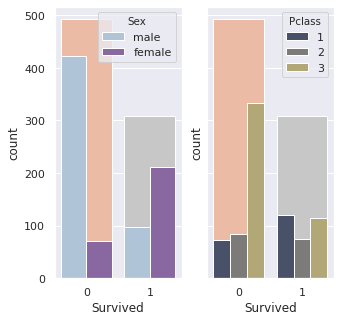

In [103]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (5,5))
sns.countplot(x="Survived", data=strat_train, ax = ax[0], palette = "RdGy")
sns.countplot(x="Survived", hue="Sex", data=strat_train, ax = ax[0], palette = "BuPu")
sns.countplot(x="Survived", data=strat_train, ax = ax[1], palette = "RdGy")
sns.countplot(x="Survived", hue="Pclass", data=strat_train, ax = ax[1], palette="cividis")

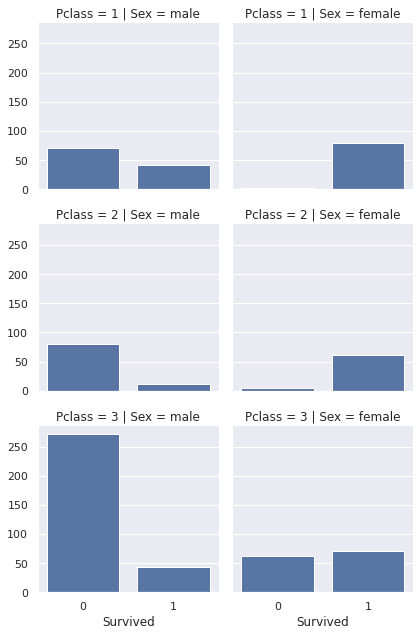

In [104]:
g = sns.FacetGrid(col="Sex", row="Pclass", data=strat_train)
g.map_dataframe(sns.countplot, "Survived")

# Labels

In [105]:
titanic_labels = titanic["Survived"].astype(int)
strat_train_labels = strat_train["Survived"].astype(int)
strat_devtest_labels = strat_devtest["Survived"].astype(int)
strat_train.drop("Survived", inplace=True, axis=1)
strat_devtest.drop("Survived", inplace=True, axis=1)

# Consider Models

## Coarse try

In [106]:
# lin_reg_pip.fit(strat_train, strat_train_labels)
# pred = lin_reg_pip.predict(strat_train)
# accuracy_score(strat_train_labels, pred)

In [107]:
log_reg_pip.fit(strat_train, strat_train_labels)
pred = log_reg_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.8077403245942572

In [108]:
sgd_clf_pip.fit(strat_train, strat_train_labels)
pred = sgd_clf_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.784019975031211

In [109]:
rndforest_clf_pip.fit(strat_train, strat_train_labels)
pred = rndforest_clf_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.982521847690387

In [110]:
dectree_clf_pip.fit(strat_train, strat_train_labels)
pred = dectree_clf_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.982521847690387

In [111]:
lin_svc_pip.fit(strat_train, strat_train_labels)
pred = lin_svc_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

/home/linuser/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7915106117353309

In [112]:
svc_pip.fit(strat_train, strat_train_labels)
pred = svc_pip.predict(strat_train)

accuracy_score(strat_train_labels, pred)

0.8439450686641697

# Random Forest

## Try various hyper params

In [113]:
strat_train_prep = attr_pip.fit_transform(strat_train)
rnd_forest = RandomForestClassifier(random_state=42)
# don't know if skfold actually makes sense here
skfold = StratifiedKFold(n_splits=15)
cross_val_score(rnd_forest, strat_train_prep, strat_train_labels, cv = skfold, scoring="accuracy")

array([0.7962963 , 0.75925926, 0.81481481, 0.81481481, 0.77777778,
       0.81481481, 0.90566038, 0.81132075, 0.8490566 , 0.73584906,
       0.86792453, 0.83018868, 0.86792453, 0.8490566 , 0.69811321])

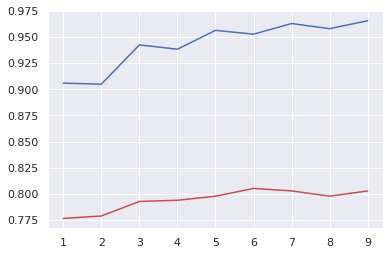

In [114]:
n_estimators_range = np.arange(1,10)
train_scores, test_scores = validation_curve(rnd_forest, strat_train_prep, strat_train_labels, param_name="n_estimators", param_range=n_estimators_range, scoring="accuracy", cv = skfold)
plt.plot(n_estimators_range, np.mean(train_scores, 1), label="train score", c='b')
plt.plot(n_estimators_range, np.mean(test_scores, 1), label="test score", c='r')

### ---> Looks like bad overfitting

In [130]:
param_grid = [
    {"random_state" : [42]},
    {"max_features" : [1,2,3,4]},
    {"max_depth" : [2,3,4]},
    {"n_estimators" : [1,2,3,4,5,6,7]},
    #{"n_estimators" : [100,200]},
    {"min_samples_split" : [3,4,5,6]},
    {"min_samples_leaf" : [2,3,4,5,6]},
    {"min_impurity_decrease" : [0.0, 0.1, 0.2]},
    {"bootstrap" : [False]},
    #{"warm_start" : [True, False]}
]

gridsearch = GridSearchCV(rnd_forest, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
gridsearch.fit(strat_train_prep, strat_train_labels)
best_rnd_forest = gridsearch.best_estimator_

In [131]:
strat_devtest_prep = attr_pip.fit_transform(strat_devtest)
pred = best_rnd_forest.predict(strat_devtest_prep)
accuracy_score(strat_devtest_labels, pred)

0.8333333333333334

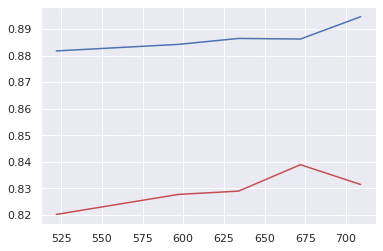

In [117]:
train_sizes, train_scores, val_scores = learning_curve(best_rnd_forest, X = strat_train_prep, y = strat_train_labels, train_sizes=[0.7, 0.8, 0.85, 0.9, 0.95], cv = skfold)
plt.plot(train_sizes, np.mean(train_scores, 1), label="train scores", c = 'b')
plt.plot(train_sizes, np.mean(val_scores, 1), label="val scores", c = 'r')

In [128]:
gridsearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Polynomial SVC

In [50]:
# poly_features = PolynomialFeatures(degree = 3)
# train_poly = poly_features.fit_transform(strat_train_prep)
# test_poly = poly_features.fit_transform(strat_devtest_prep)

# linsvc = LinearSVC(C=5, loss="hinge", max_iter=2000, random_state=42)
# linsvc.fit(train_poly, strat_train_labels)
# pred = linsvc.predict(test_poly)

# accuracy_score(strat_devtest_labels, pred)

In [51]:
# C = [5,10]
# train_scores, test_scores = validation_curve(linsvc, train_poly, strat_train_labels, param_name="C", param_range=C, scoring="accuracy", cv = skfold)
# plt.plot(C, np.mean(train_scores, 1), label="train score", c='b')
# plt.plot(C, np.mean(test_scores, 1), label="test score", c='r')


In [118]:
# svc = SVC(random_state=42, probability=True)

In [119]:
# param_grid = [
#     {"random_state" : [42]},
#     {"C" : [2,3,4,5,6,7,8,9,10,15]},
#     {"kernel" : ["poly"]},
#     {"degree" : [1,2,3,4]},
#     {"coef0" : [1,2,3,4,5,6]}
# ]

# gridsearch = GridSearchCV(svc, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
# gridsearch.fit(strat_train_prep, strat_train_labels)
# best_svc = gridsearch.best_estimator_

In [120]:
# strat_devtest_prep = attr_pip.fit_transform(strat_devtest)
# pred = best_svc.predict(strat_devtest_prep)
# accuracy_score(strat_devtest_labels, pred)

In [121]:
# best_svc.fit(strat_train_prep, strat_train_labels)
# pred = best_svc.predict(strat_train_prep)

# accuracy_score(strat_train_labels, pred)

# Ensemble

In [122]:
# voting_clf = VotingClassifier(
#     estimators=[("rf", best_rnd_forest), ("dt", best_dec_tree), ("svc", best_svc), ("log", LogisticRegression())], voting="soft"
# )

# # voting_clf = VotingClassifier(
# #     estimators=[("rf", RandomForestClassifier(random_state=42)), ("dt", LogisticRegression()), ("svc", SVC(C = 10, probability=True))], voting="soft"
# # )


# voting_clf.fit(strat_train_prep, strat_train_labels)

# pred = voting_clf.predict(strat_devtest_prep)
# accuracy_score(strat_devtest_labels, pred)

In [123]:
# ada_clf = AdaBoostClassifier(voting_clf, algorithm="SAMME.R", learning_rate=0.5)
# ada_clf.fit(strat_train_prep, strat_train_labels)

# pred = ada_clf.predict(strat_devtest_prep)
# accuracy_score(strat_devtest_labels, pred)

In [124]:
# bag_clf = BaggingClassifier(voting_clf, bootstrap=True)

# bag_clf.fit(strat_train_prep, strat_train_labels)

# pred = bag_clf.predict(strat_devtest_prep)
# accuracy_score(strat_devtest_labels, pred)

# Predict test set

In [125]:
#best_model = RandomForestClassifier(random_state=42)
best_model = best_rnd_forest
#best_model = ada_clf
best_model = voting_clf
best_model = best_svc

In [126]:
full_train = titanic.drop("Survived", axis=1)
full_train_prep = attr_pip.fit_transform(full_train)
best_model.fit(full_train_prep, titanic_labels)

test = pd.read_csv("test.csv")
test_prep = attr_pip.fit_transform(test)
titanic_prep = attr_pip.fit_transform(titanic)

#sgd_clf.fit(titanic_prep, titanic_labels)
#survival_pred = sgd_clf.predict(test_prep)

survival_pred = best_model.predict(test_prep)

survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv("predicition.csv")
id_survival

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
